# MS025 Preprocess
Created: 01/29/2024 \
Updated: 04/07/2024

In [1]:
import numpy as np
import mne
from glob import glob
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import seaborn as sns
from scipy.stats import zscore, linregress, ttest_ind, ttest_rel, ttest_1samp
import pandas as pd
from mne.preprocessing.bads import _find_outliers
import os 
import joblib
import re
import datetime
import scipy


import warnings
warnings.filterwarnings('ignore')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/LFPAnalysis/')

In [4]:
from LFPAnalysis import lfp_preprocess_utils, sync_utils, analysis_utils, nlx_utils

In [5]:
# Specify root directory for un-archived data and results 
base_dir = '/sc/arion/projects/guLab/Alie/SWB/'
anat_dir = f'{base_dir}ephys_analysis/recon_labels/'
neural_dir = f'{base_dir}ephys_analysis/data/'
behav_dir = f'{base_dir}swb_behav_models/data/behavior_preprocessed/'

subj_id = 'MS025'
subj_format = ['nlx']
subj_site = ['MSSM']


# Make mne_data


### Load and resample data


In [6]:
load_path = f'{neural_dir}{subj_id}/raw_nlx/'
seeg_names = None
resp_names = None
ekg_names = None
eeg_names = None

In [7]:
### removing extraneous numbering from channel names 

# per Shawn, MSSM data seems to sometime have a "_0000.ncs" to "_9999.ncs" appended to the end of real data
pattern = re.compile(r"_\d{4}\.ncs")  # regex pattern to match "_0000.ncs" to "_9999.ncs"
ncs_files = [x for x in glob(f'{load_path}/*.ncs') if re.search(pattern, x)]
# just in case this changes in the future: 
if len(ncs_files) == 0: 
    ncs_files = glob(f'{load_path}/*.ncs')
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','') for x in glob(f'{load_path}/[R,L]*.ncs')]
else:
    if not seeg_names:
        seeg_names = [x.split('/')[-1].replace('.ncs','').split('_')[0] for x in glob(f'{load_path}/[R,L]*.ncs') if re.search(pattern, x)]

In [8]:
seeg_names = [x.lower() for x in seeg_names] 
seeg_names

['rhplt4',
 'lptpt4',
 'lcmip1',
 'racas12',
 'rpvnh10',
 'lpvnh9',
 'rcmip14',
 'raglt7',
 'lhplt7',
 'lptpt8',
 'lacas2',
 'laglt1',
 'lpvnh2',
 'laglt2',
 'lmolf1',
 'lacas10',
 'lcmip14',
 'lacas9',
 'lacas3',
 'racas3',
 'lcmip11',
 'rcmip3',
 'rhplt2',
 'lacas8',
 'lmolf5',
 'lcmip6',
 'racas7',
 'lptpt1',
 'lhplt11',
 'lhplt5',
 'rcmip4',
 'lcmip9',
 'lmolf9',
 'rhplt9',
 'lptpt2',
 'lmolf8',
 'rpvnh1',
 'lpvnh13',
 'lpvnh12',
 'rmolf5',
 'lmcms4',
 'lpvnh14',
 'racas9',
 'racas5',
 'raglt5',
 'lmolf6',
 'rcmip11',
 'rmcms9',
 'lmcms10',
 'lmcms2',
 'rpvnh4',
 'lptpt9',
 'racas2',
 'rcmip7',
 'rhplt7',
 'racas1',
 'lmcms5',
 'lacas12',
 'lmcms9',
 'laglt5',
 'raglt4',
 'lacas4',
 'rcmip13',
 'rmolf3',
 'rcmip5',
 'raglt1',
 'rmcms5',
 'rhplt1',
 'lpvnh10',
 'raglt8',
 'rhplt6',
 'rmolf2',
 'lcmip7',
 'lcmip8',
 'lhplt6',
 'racas4',
 'lacas11',
 'lpvnh3',
 'lmcms3',
 'rmolf4',
 'rhplt10',
 'rpvnh6',
 'rcmip8',
 'raglt9',
 'laglt3',
 'lacas7',
 'rmcms2',
 'rpvnh8',
 'rpvnh3',
 'la

In [9]:
### empty vecs to load data into 

signals = [] #data
srs = [] #sampling rate
ch_name = [] #channel name
ch_type = [] #channel type (seeg, eeg etc.)

In [10]:
ncs_files.sort() ### added to make channels in alphabetical order 

In [11]:
ncs_files

['/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT1_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT2_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT3_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT4_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT5_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT6_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT7_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT8_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LAglT9_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LCMiP10_0012.ncs',
 '/sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_nlx/LCMiP11_0012.ncs',
 '/sc/arion/projects/guLab/Ali

In [12]:
for chan_path in ncs_files:
    chan_name = chan_path.split('/')[-1].replace('.ncs','')
    # strip the file type off the end if needed 
    if '_' in chan_name:
        chan_name = chan_name.split('_')[0]
    try:
        fdata = nlx_utils.load_ncs(chan_path)
    except IndexError: 
        print(f'No data in channel {chan_name}')
        continue
    if eeg_names:
        if chan_name.lower() in eeg_names:
            ch_type.append('eeg')
    if resp_names:
        if chan_name.lower() in resp_names:
            ch_type.append('bio')
    if ekg_names:
        if chan_name.lower() in ekg_names: 
            ch_type.append('ecg') 
    if seeg_names: 
        if chan_name.lower() in seeg_names:
            ch_type.append('seeg')  
        elif chan_name.lower()[0] == 'u':
            # microwire data
            ch_type.append('seeg')  
    signals.append(fdata['data'])
    srs.append(fdata['sampling_rate'])
    ch_name.append(chan_name)
    if len(ch_type) < len(ch_name):
        ch_type.append('misc')
        print(f'Unidentified data type in {chan_name}') #this output should tell you what your photodiode name is

Unidentified data type in Photodiode


In [13]:
ch_name

['LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMiP10',
 'LCMiP11',
 'LCMiP12',
 'LCMiP13',
 'LCMiP14',
 'LCMiP1',
 'LCMiP2',
 'LCMiP3',
 'LCMiP4',
 'LCMiP5',
 'LCMiP6',
 'LCMiP7',
 'LCMiP8',
 'LCMiP9',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT1',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LPVNH10',
 'LPVNH11',
 'LPVNH12',
 'LPVNH13',
 'LPVNH14',
 'LPVNH1',
 'LPVNH2',
 'LPVNH3',
 'LPVNH4',
 'LPVNH5',
 'LPVNH6',
 'LPVNH7',
 'LPVNH8',
 'LPVNH9',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS1',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LmCmS10',
 'LmCmS11',
 'LmCmS12',
 'LmCmS1',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LpTpT10',
 'LpTpT1',
 'LpTpT2',
 'LpTpT3',
 'LpTpT4',
 'LpTpT5',
 'LpTpT6',
 

In [14]:
srs

[2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,
 2000,

In [15]:
target_sr = 500 #downsampling to 500 to be consistent with other data - alternative = np.min(srs)
mne_data_resampled = []

In [16]:
### resampling to 500Hz

for sr in np.unique(srs):
    ch_ix = np.where(srs==sr)[0].astype(int)
    info = mne.create_info([x for ix, x in enumerate(ch_name) if ix in ch_ix], sr, [x for ix, x in enumerate(ch_type) if ix in ch_ix])
    mne_data_temp = mne.io.RawArray([x for ix, x in enumerate(signals) if ix in ch_ix], info)
    if sr != target_sr:
        # resample down to one sample rate 
        mne_data_temp.resample(sfreq=target_sr, npad='auto', n_jobs=-1)
        mne_data_resampled.append(mne_data_temp)
    else: 
        mne_data = mne_data_temp
        

Creating RawArray with float64 data, n_channels=169, n_times=5078016
    Range : 0 ... 5078015 =      0.000 ...  2539.008 secs
Ready.


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:   49.6s
[Parallel(n_jobs=-1)]: Done 169 out of 169 | elapsed:   52.1s finished


In [17]:
### make sure timing is aligned post resampling --- check this 

#Because of the resampling, the end timings might not match perfectly:https://github.com/mne-tools/mne-python/issues/8257

if mne_data_resampled[0].tmax > mne_data_temp.tmax:
    mne_data_resampled[0].crop(tmin=0, tmax=mne_data_temp.tmax)
elif mne_data_resampled[0].tmax < mne_data_temp.tmax:
    mne_data_temp.crop(tmin=0, tmax=mne_data_resampled[0].tmax)
    

In [18]:
mne_data_resampled[0]

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [19]:
mne_data = mne_data_resampled[0]  #mne_data.add_channels([mne_data_temp]) to add more channels input mne object as list
# mne_data.add_channels([mne_data_resampled[1]])
mne_data

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [20]:
mne_data

<RawArray | 169 x 1269504 (2539.0 s), ~1.60 GB, data loaded>

In [21]:
# mne_data.ch_names

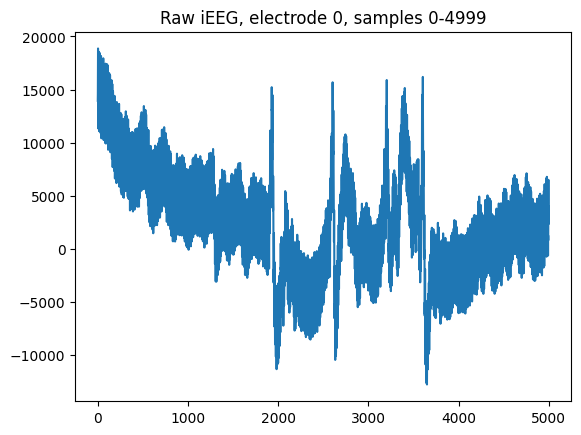

In [21]:
# Sanity check one channel data

plt.plot(mne_data._data[0,:4999])
plt.title("Raw iEEG, electrode 0, samples 0-4999")
plt.show()

### Photodiode
- examine photodiode 

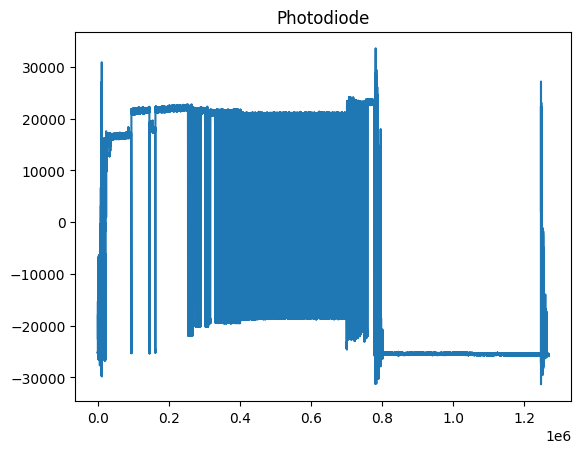

In [21]:
# Sanity check the photodiode
trig_ix = mne_data.ch_names.index("Photodiode")
plt.plot(mne_data._data[trig_ix])
plt.title("Photodiode")
plt.show()

In [23]:
mne_data.save(f'{neural_dir}{subj_id}/photodiode.fif', picks='Photodiode', overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/photodiode.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/photodiode.fif
[done]


In [24]:
mne_data.drop_channels(['Photodiode'])

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

### Notch filter line noise

In [25]:
mne_data.info['line_freq'] = 60
# Notch out 60 Hz noise and harmonics 
mne_data.notch_filter(freqs=(60, 120, 180, 240))

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 168 out of 168 | elapsed:    6.7s finished


<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

### Anatomical Localization

In [26]:
### Rename channels to be lowercase before anatomical localization
new_name_dict = {x:x.replace(" ", "").lower() for x in mne_data.ch_names}
mne_data.rename_channels(new_name_dict)

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [27]:
# Load the electrode localization data
anat_file = glob(f'{anat_dir}{subj_id}_labels.csv')[0]
elec_locs = pd.read_csv(anat_file)
# Sometimes there's extra columns with no entries: 
elec_locs = elec_locs[elec_locs.columns.drop(list(elec_locs.filter(regex='Unnamed')))]

elec_locs

,label,BN246label,x,y,z,mni_x,mni_y,mni_z,gm,NMM,Anat,AnatMacro,BN246,YBA_1,ManualExamination,notes
0,LaCaS1,A32sg_L,-8.551953,47.560752,20.574440,-7.364096,42.879442,7.816402,Gray,Left ACgG anterior cingulate gyrus,Unknown,L ACC,L CG,Left cingulate gyrus F,NaN,NaN
1,LaCaS10,Unknown,-17.348071,64.346899,55.331263,-15.943065,67.827566,42.142829,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
2,LaCaS11,Unknown,-17.747895,65.545910,58.127789,-16.252304,69.749974,44.950649,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
3,LaCaS12,Unknown,-17.747895,65.945580,59.725803,-16.193126,70.554453,46.641912,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,OOB,NaN
4,LaCaS2,A32p_L,-9.751424,49.559103,24.968981,-8.600387,46.074869,12.332196,Gray,Left MSFG superior frontal gyrus medial segment,Unknown,L ACC,L CG,Left frontal pole 4 A,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167,RPVNH9,mOccG_R,29.431284,-69.942282,-4.993797,29.084658,-86.459783,9.976051,White,Right Cerebral White Matter,Area hOc4lp,R Middle Occipital Gyrus,R LOcC,Right superior middle occipital gyrus D,NaN,NaN
168,uLAglT,rHipp_L,-16.148600,10.391424,-14.981390,-16.594453,-3.626931,-23.761121,Gray,Left Amygdala,Amygdala (LB),L ParaHippocampal Gyrus,L Hipp,Left parahippocampal gyrus A,Left amygdala inferior,NaN
169,uLmOlF,A11m_L,-8.951776,61.549208,-4.594294,-7.639574,50.840300,-25.038950,Gray,Left MOrG medial orbital gyrus,Area Fo1,L Superior Orbital Gyrus,L OrG,Left frontal orbital 2 B,NaN,NaN
170,uRAglT,rHipp_R,15.037636,10.391424,-14.182383,17.162481,-3.723941,-23.243948,Gray,Right Amygdala,Amygdala (LB),R ParaHippocampal Gyrus,R Hipp,Right amygdala inferior,NaN,NaN


In [28]:
list(elec_locs.label)

['LaCaS1',
 'LaCaS10',
 'LaCaS11',
 'LaCaS12',
 'LaCaS2',
 'LaCaS3',
 'LaCaS4',
 'LaCaS5',
 'LaCaS6',
 'LaCaS7',
 'LaCaS8',
 'LaCaS9',
 'LAglT1',
 'LAglT2',
 'LAglT3',
 'LAglT4',
 'LAglT5',
 'LAglT6',
 'LAglT7',
 'LAglT8',
 'LAglT9',
 'LCMiP1',
 'LCMiP10',
 'LCMiP11',
 'LCMiP12',
 'LCMiP13',
 'LCMiP14',
 'LCMiP2',
 'LCMiP3',
 'LCMiP4',
 'LCMiP5',
 'LCMiP6',
 'LCMiP7',
 'LCMiP8',
 'LCMiP9',
 'LHplT1',
 'LHplT10',
 'LHplT11',
 'LHplT12',
 'LHplT2',
 'LHplT3',
 'LHplT4',
 'LHplT5',
 'LHplT6',
 'LHplT7',
 'LHplT8',
 'LHplT9',
 'LmCmS1',
 'LmCmS10',
 'LmCmS11',
 'LmCmS12',
 'LmCmS2',
 'LmCmS3',
 'LmCmS4',
 'LmCmS5',
 'LmCmS6',
 'LmCmS7',
 'LmCmS8',
 'LmCmS9',
 'LmOlF1',
 'LmOlF2',
 'LmOlF3',
 'LmOlF4',
 'LmOlF5',
 'LmOlF6',
 'LmOlF7',
 'LmOlF8',
 'LmOlF9',
 'LmTpT1',
 'LmTpT10',
 'LmTpT2',
 'LmTpT3',
 'LmTpT4',
 'LmTpT5',
 'LmTpT6',
 'LmTpT7',
 'LmTpT8',
 'LmTpT9',
 'LPVNH1',
 'LPVNH10',
 'LPVNH11',
 'LPVNH12',
 'LPVNH13',
 'LPVNH14',
 'LPVNH2',
 'LPVNH3',
 'LPVNH4',
 'LPVNH5',
 'LPVNH6',
 

In [29]:
anat_names = list(elec_locs.label.str.lower())
sum([ch not in mne_data.ch_names for ch in anat_names]) #if there are no missing channels, sum = 0. if sum >0, find the missing elecs
print([ch for ch in mne_data.ch_names if ch not in anat_names ]) #print extra channels in mne_data.ch_names and make sure none of them are neural channels (will be EEG etc.)

['lptpt10', 'lptpt1', 'lptpt2', 'lptpt3', 'lptpt4', 'lptpt5', 'lptpt6', 'lptpt7', 'lptpt8', 'lptpt9']


In [30]:
new_mne_names, unmatched_names, unmatched_seeg = lfp_preprocess_utils.match_elec_names(mne_data.ch_names, elec_locs.label)


Number of electrodes in the mne file is less than the number of electrodes in the localization file


In [31]:
unmatched_seeg #make sure there are no unmatched names


[]

In [32]:
new_name_dict = {x:y for (x,y) in zip(mne_data.ch_names, new_mne_names)}


In [33]:
new_name_dict #make sure this passes the eye test 


{'laglt1': 'laglt1',
 'laglt2': 'laglt2',
 'laglt3': 'laglt3',
 'laglt4': 'laglt4',
 'laglt5': 'laglt5',
 'laglt6': 'laglt6',
 'laglt7': 'laglt7',
 'laglt8': 'laglt8',
 'laglt9': 'laglt9',
 'lcmip10': 'lcmip10',
 'lcmip11': 'lcmip11',
 'lcmip12': 'lcmip12',
 'lcmip13': 'lcmip13',
 'lcmip14': 'lcmip14',
 'lcmip1': 'lcmip1',
 'lcmip2': 'lcmip2',
 'lcmip3': 'lcmip3',
 'lcmip4': 'lcmip4',
 'lcmip5': 'lcmip5',
 'lcmip6': 'lcmip6',
 'lcmip7': 'lcmip7',
 'lcmip8': 'lcmip8',
 'lcmip9': 'lcmip9',
 'lhplt10': 'lhplt10',
 'lhplt11': 'lhplt11',
 'lhplt12': 'lhplt12',
 'lhplt1': 'lhplt1',
 'lhplt2': 'lhplt2',
 'lhplt3': 'lhplt3',
 'lhplt4': 'lhplt4',
 'lhplt5': 'lhplt5',
 'lhplt6': 'lhplt6',
 'lhplt7': 'lhplt7',
 'lhplt8': 'lhplt8',
 'lhplt9': 'lhplt9',
 'lpvnh10': 'lpvnh10',
 'lpvnh11': 'lpvnh11',
 'lpvnh12': 'lpvnh12',
 'lpvnh13': 'lpvnh13',
 'lpvnh14': 'lpvnh14',
 'lpvnh1': 'lpvnh1',
 'lpvnh2': 'lpvnh2',
 'lpvnh3': 'lpvnh3',
 'lpvnh4': 'lpvnh4',
 'lpvnh5': 'lpvnh5',
 'lpvnh6': 'lpvnh6',
 'lpvnh7

In [34]:
# Rename the mne data according to the localization data

mne_data.rename_channels(new_name_dict)

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [35]:
right_seeg_names = [i for i in mne_data.ch_names if i.startswith('r')]
left_seeg_names = [i for i in mne_data.ch_names if i.startswith('l')]
print(f'We have a total of {len(left_seeg_names)} left sEEG and {len(right_seeg_names)} right sEEG electrodes')
print(f'We have a total of {len(left_seeg_names) + len(right_seeg_names)} sEEG electrodes')



We have a total of 92 left sEEG and 76 right sEEG electrodes
We have a total of 168 sEEG electrodes


In [36]:
sEEG_mapping_dict = {f'{x}':'seeg' for x in left_seeg_names+right_seeg_names}
mne_data.set_channel_types(sEEG_mapping_dict)


<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [37]:
drop_chans = list(set(mne_data.ch_names)^set(left_seeg_names+right_seeg_names))
mne_data.drop_channels(drop_chans) #number of chans should = number of seegs 

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

In [38]:
# make montage (convert mm to m)

montage = mne.channels.make_dig_montage(ch_pos=dict(zip(elec_locs.label, 
                                                        elec_locs[['mni_x', 'mni_y', 'mni_z']].to_numpy(dtype=float)/1000)),
                                        coord_frame='mni_tal')

mne_data.set_montage(montage, match_case=False, on_missing='warn')

<RawArray | 168 x 1269504 (2539.0 s), ~1.59 GB, data loaded>

## Signal Cleaning 
Methods:
- Use manual bad channel detection for **bipolar** referencing
    - bipolar referencing completely ignores channels labeled as 'bad' so do not remove unless absolutely necessary
    - remove ch if there is massive artifact in a channel not in the rest of probe 
    - if entire probe shows same artifact try to keep
- Remove additional channels as needed
- This process is iterative depending on how TFRs look. 

In [39]:
#this is just for my own personal info and to select how many channels to visualize at a time
ch_names = list(elec_locs.label.str.lower())
pattern = '[0-9]'
ch_names_no_num = [re.sub(pattern, '', i) for i in ch_names]
probe_names = np.unique(ch_names_no_num)
# probe_names

In [40]:
probe_ch_counts = {} #need this to select channel number for visualization
for p in probe_names:
    c = ch_names_no_num.count(p)
    probe_ch_counts[p] = c

In [41]:
probe_ch_counts

{'lacas': 12,
 'laglt': 9,
 'lcmip': 14,
 'lhplt': 12,
 'lmcms': 12,
 'lmolf': 9,
 'lmtpt': 10,
 'lpvnh': 14,
 'racas': 12,
 'raglt': 9,
 'rcmip': 14,
 'rhplt': 10,
 'rmcms': 10,
 'rmolf': 9,
 'rpvnh': 12,
 'ulaglt': 1,
 'ulmolf': 1,
 'uraglt': 1,
 'urmolf': 1}

### Compare auto detection result to actual lfp data - if trusted save auto result as mne bads
- often inaccurate - verify that all included channels make sense and all channels that should be included are
- take out any crazy noise, especially if it's only in one channel on probe (won't be cancelled out)

In [42]:
# mne_data.info['bads'] = lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) #this is likely inaccurate - just use to get an idea 
lfp_preprocess_utils.detect_bad_elecs(mne_data, sEEG_mapping_dict) # good for this patient

['lacas11',
 'lacas12',
 'laglt1',
 'lcmip8',
 'lhplt1',
 'lhplt2',
 'lmcms1',
 'lmcms12',
 'lmcms2',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'racas10',
 'racas9',
 'raglt7',
 'rhplt2',
 'rmolf8',
 'rmolf9']

<IPython.core.display.Javascript object>


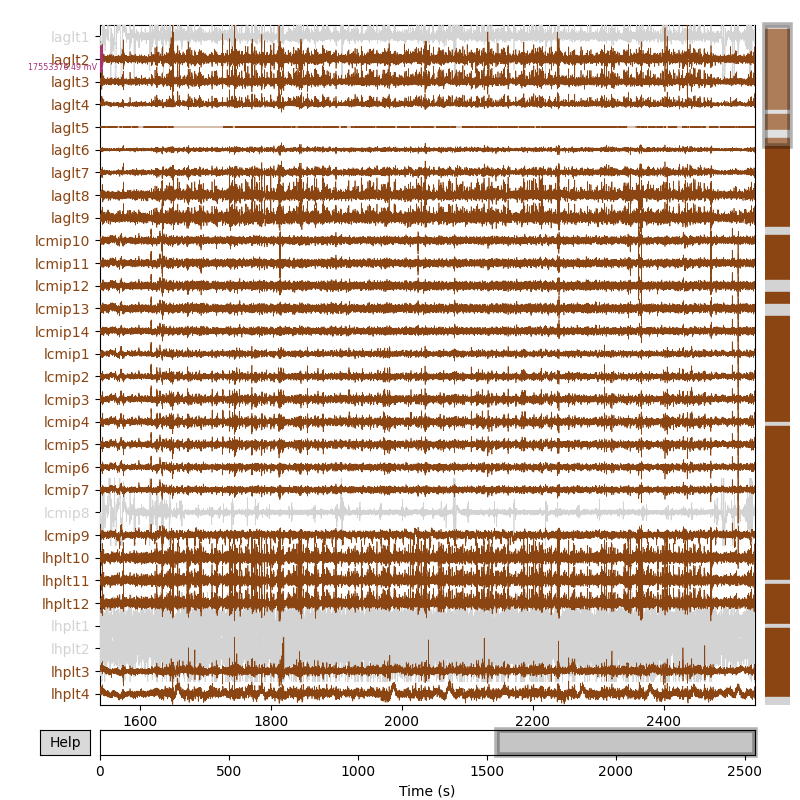

In [67]:
 %matplotlib notebook
fig = mne_data.plot(start=0, duration=1000, n_channels=30, scalings=mne_data._data.max()/5)


In [39]:
mne_data.info['bads'] = ['lcmip8',
 'lacas12',
 'lmcms1',
 'lmcms12',
 'lmcms2',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'raglt7',
 'racas10',
 'rmolf8',
 'rmolf9',
 'racas9',
 'laglt1',
 'lacas11',
 'lhplt1',
 'lhplt2']

In [66]:
mne_data.info['bads'] = ['lcmip8',
 'lacas12',
 'lmcms1',
 'lmcms12',
 'lmcms2',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'raglt7',
 'racas10',
 'rmolf8',
 'rmolf9',
 'racas9',
 'laglt1',
 'lacas11',
 'lhplt1',
 'lhplt2'] # 04/05/2024

['lcmip8',
 'lacas12',
 'lmcms1',
 'lmcms12',
 'lmcms2',
 'lmcms6',
 'lmcms7',
 'lmcms8',
 'raglt7',
 'racas10',
 'rmolf8',
 'rmolf9',
 'racas9',
 'laglt1',
 'lhplt1',
 'lhplt2',
 'lacas11']

In [57]:
# mne_data.info['bads'] = ['laglt1',
#  'lhplt1',
#  'lhplt2',
#  'lcmip8',
#  'lacas12',
#  'lacas10',
#  'lacas11',
#  'lmcms12',
#  'lmcms1',
#  'lmcms2',
#  'lmcms6',
#  'lmcms7',
#  'lmcms8',
#  'raglt7',
#  'racas10',
#  'racas9',
#  'rmolf8',
#  'rmolf9'] # old 1/29/24

In [40]:
mne_data.info #sanity check that bads info saved

<Info | 10 non-empty values
 bads: 17 items (lcmip8, lacas12, lmcms1, lmcms12, lmcms2, lmcms6, ...)
 ch_names: laglt1, laglt2, laglt3, laglt4, laglt5, laglt6, laglt7, laglt8, ...
 chs: 168 sEEG
 custom_ref_applied: False
 dig: 168 items (168 EEG)
 highpass: 0.0 Hz
 line_freq: 60.0
 lowpass: 250.0 Hz
 meas_date: unspecified
 nchan: 168
 projs: []
 sfreq: 500.0 Hz
>

# Bipolar Re-referencing 
- plot lfp bp data
- plot psd bp data
- save bp reref data 


In [41]:
#run if only re-ref
anat_file = glob(f'{anat_dir}/{subj_id}_labels.csv')[0]
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif', preload=True)

### Bipolar Re-ref

In [42]:
# Re-reference neural data
mne_data_bp_reref = lfp_preprocess_utils.ref_mne(mne_data=mne_data, 
                                              elec_path=anat_file, 
                                              method='bipolar', 
                                              site='MSSM')

Number of electrodes in the mne file is less than the number of electrodes in the localization file
sEEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=87, n_times=1269504
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Added the following bipolar channels:
lacas1-lacas2, lacas2-lacas3, lacas3-lacas4, lacas5-lacas6, laglt2-laglt3, laglt3-laglt4, laglt6-laglt7, laglt7-laglt8, laglt8-laglt9, lcmip1-lcmip2, lcmip2-lcmip3, lcmip3-lcmip4, lcmip4-lcmip5, lcmip5-lcmip6, lcmip7-lcmip9, lcmip9-lcmip10, lcmip10-lcmip11, lcmip13-lcmip14, lhplt3-lhplt4, lhplt4-lhplt5, lhplt8-lhplt9, lhplt9-lhplt10, lmcms3-lmcms4, lmcms4-lmcms5, lmcms5-lmcms9, lmolf1-lmolf2, lmolf2-lmolf3, lmolf3-lmolf4, lmolf4-lmolf5, lmolf5-lmolf6, lmolf6-lmolf7, lmolf7-lmolf8, lmtpt1-lmtpt2, lmtpt2-lmtpt3, lmtpt5-lmtpt6, lmtpt6-lmtpt7, lmtpt7-lmtpt8, lmtpt8-lmtpt9, lmtpt9-lmtpt10, lpvnh1-lpvnh2, lpvnh2-lpvnh3, lpvnh3-lpvnh4, lpvnh4-lpvnh5, lpvnh5-lpvnh6, lpvnh6-lpvnh7, l

In [43]:
mne_data_bp_reref

<RawArray | 87 x 1269504 (2539.0 s), ~842.8 MB, data loaded>

In [44]:
mne_data_bp_reref.ch_names

['lacas1-lacas2',
 'lacas2-lacas3',
 'lacas3-lacas4',
 'lacas5-lacas6',
 'laglt2-laglt3',
 'laglt3-laglt4',
 'laglt6-laglt7',
 'laglt7-laglt8',
 'laglt8-laglt9',
 'lcmip1-lcmip2',
 'lcmip2-lcmip3',
 'lcmip3-lcmip4',
 'lcmip4-lcmip5',
 'lcmip5-lcmip6',
 'lcmip7-lcmip9',
 'lcmip9-lcmip10',
 'lcmip10-lcmip11',
 'lcmip13-lcmip14',
 'lhplt3-lhplt4',
 'lhplt4-lhplt5',
 'lhplt8-lhplt9',
 'lhplt9-lhplt10',
 'lmcms3-lmcms4',
 'lmcms4-lmcms5',
 'lmcms5-lmcms9',
 'lmolf1-lmolf2',
 'lmolf2-lmolf3',
 'lmolf3-lmolf4',
 'lmolf4-lmolf5',
 'lmolf5-lmolf6',
 'lmolf6-lmolf7',
 'lmolf7-lmolf8',
 'lmtpt1-lmtpt2',
 'lmtpt2-lmtpt3',
 'lmtpt5-lmtpt6',
 'lmtpt6-lmtpt7',
 'lmtpt7-lmtpt8',
 'lmtpt8-lmtpt9',
 'lmtpt9-lmtpt10',
 'lpvnh1-lpvnh2',
 'lpvnh2-lpvnh3',
 'lpvnh3-lpvnh4',
 'lpvnh4-lpvnh5',
 'lpvnh5-lpvnh6',
 'lpvnh6-lpvnh7',
 'lpvnh7-lpvnh8',
 'lpvnh8-lpvnh9',
 'lpvnh9-lpvnh10',
 'lpvnh12-lpvnh13',
 'racas1-racas2',
 'racas2-racas3',
 'racas3-racas4',
 'racas4-racas5',
 'racas5-racas6',
 'racas6-racas7',


#### Examine bp ref data 
- examine lfp plot to see if major artifacts are still present
- examine psd to see if there are any major peaks in channels

<IPython.core.display.Javascript object>


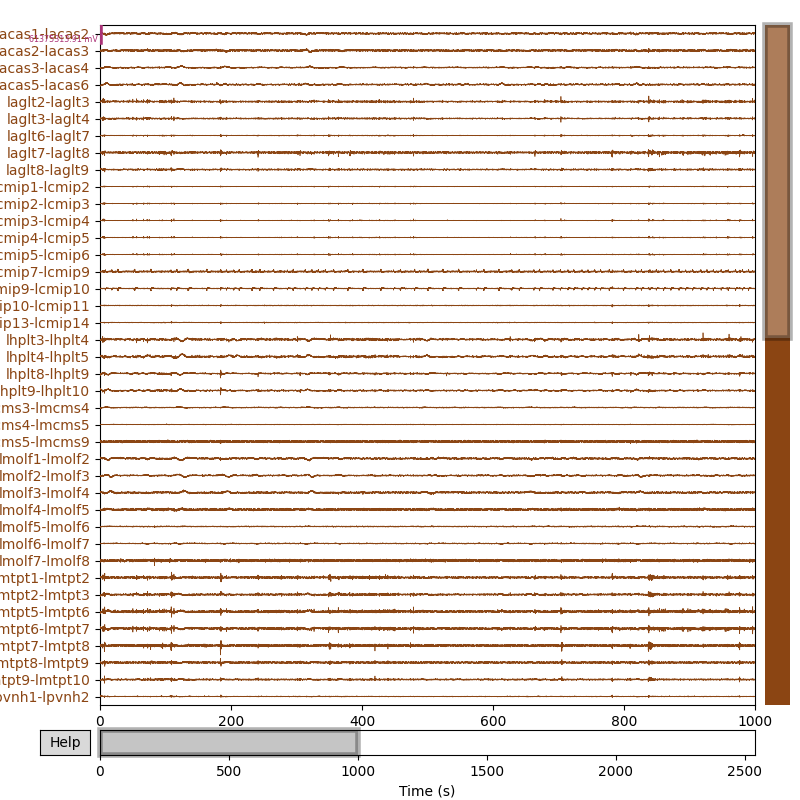

In [64]:
 %matplotlib notebook
fig = mne_data_bp_reref.plot(start=0, duration=1000, n_channels=40, scalings=mne_data_bp_reref._data.max())


Effective window size : 0.512 (s)


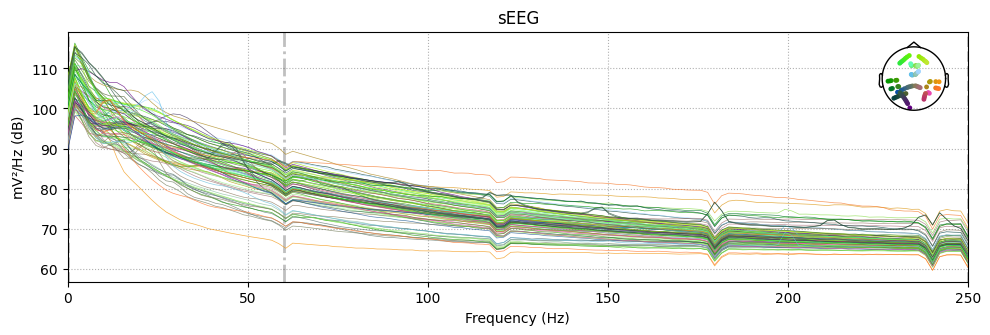

In [45]:
mne_data_bp_reref.compute_psd().plot()

In [46]:
mne_data_bp_reref.save(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif
[done]


## Save mne_data

In [47]:
mne_data.save(f'{neural_dir}{subj_id}/raw_ieeg.fif',overwrite=True)

Overwriting existing file.
Writing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_ieeg.fif
Closing /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/raw_ieeg.fif
[done]


# Epoching + TFRs
- Check whether data is ready to be analyzed - if this step shows noise then steps above should be repeated
- Align photodiode to behavior 
- Epoch data (and mark bad epochs)
- Baseline data
- Visualize TFRs 

In [48]:
#remove mne_data from environment to save memory 
del mne_data, mne_data_bp_reref

### Photodiode Alignment

In [49]:
#load behavior data
behav_df = pd.read_csv(f'{behav_dir}{subj_id}_pt_task_data')
behav_df = behav_df[behav_df.columns.drop(list(behav_df.filter(regex='Unnamed')))]
# behav_df = behav_df[behav_df['FeedbackOnset'] != 0] #remove fail trials from behav df
beh_ts = behav_df['TrialOnset'] #timestamp that should be aligned to photodiode 
#load photodiode data
photodiode_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/photodiode.fif', preload=True)

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/photodiode.fif...
Isotrak not found
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...


In [50]:
photodiode_data

<Raw | photodiode.fif, 1 x 1269504 (2539.0 s), ~9.7 MB, data loaded>

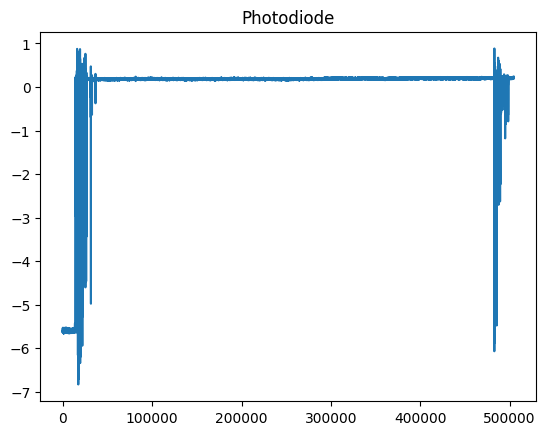

In [71]:
# Sanity check the photodiode
# plt.plot(-photodiode_data._data[0,:780000])
# plt.plot(scipy.stats.zscore(-photodiode_data._data[0,765000:]))
plt.title("Photodiode")
plt.show()

In [72]:
temp_diode = photodiode_data.copy()
temp_data = -temp_diode._data[0,:]
temp_data[0:250000] = np.min(temp_diode._data[0,:])
temp_data[765000:] = np.min(temp_diode._data[0,:])
temp_diode._data = temp_data

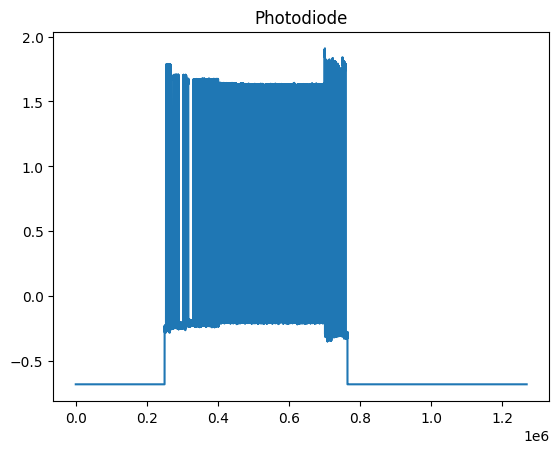

In [74]:
# plt.plot(temp_diode._data[:])
plt.plot(scipy.stats.zscore(temp_diode._data[:]))
plt.title("Photodiode")
plt.show()

In [90]:
### Photodiode alignment
smoothSize=11
windSize=15
height=1.0


# Synchronize to the photodiode or whatever your neural sync signal is
slope, offset = sync_utils.synchronize_data(beh_ts, 
                                            temp_diode, #
                                            smoothSize, windSize, height)

5 blocks
.....

found matches for 60 of 81 pulses


In [91]:
print(slope,offset)

0.9999970698598646 325.35255137919387


In [93]:
#### verify photodiode alignment
    # requires newer functions from new sync utils package (older version used here)

def get_neural_ts_photodiode(mne_sync, smoothSize=11, height=0.5):
    """
    get neural ts from photodiode
    """

    sig = np.squeeze(moving_average(mne_sync._data, n=smoothSize))
    timestamp = np.squeeze(np.arange(len(sig))/mne_sync.info['sfreq'])
    sig = scipy.stats.zscore(sig)

    trig_ix = np.where((sig[:-1]<=height)*(sig[1:]>height))[0] # rising edge of trigger
    
    neural_ts = timestamp[trig_ix]
    neural_ts = np.array(neural_ts)

    return neural_ts


def moving_average(a, n=11) :
    """
    Computes the moving average of a given array a with a window size of n.

    Parameters
    ----------
    a : np.ndarray
        The input array to compute the moving average on.
    n : int, optional
        The window size of the moving average. Default is 11.

    Returns
    -------
    np.ndarray
        The moving average of the input array a.
    """
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n


In [94]:


pulses = [(x*slope + offset) for x in beh_ts]
# moving_average
neural_ts = get_neural_ts_photodiode(temp_diode, smoothSize=15, height=0.7)
neural_ts.shape




(81,)

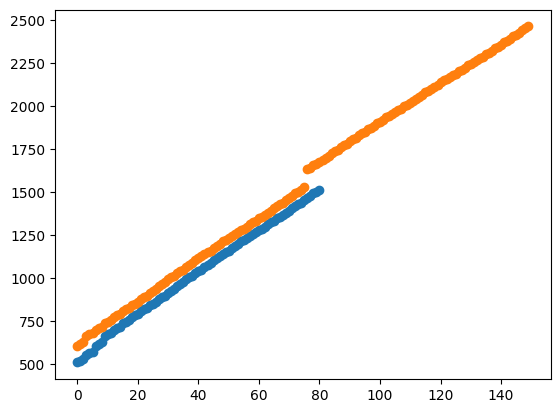

In [95]:
plt.plot(neural_ts,'o')
plt.plot(pulses,'o')
plt.show()


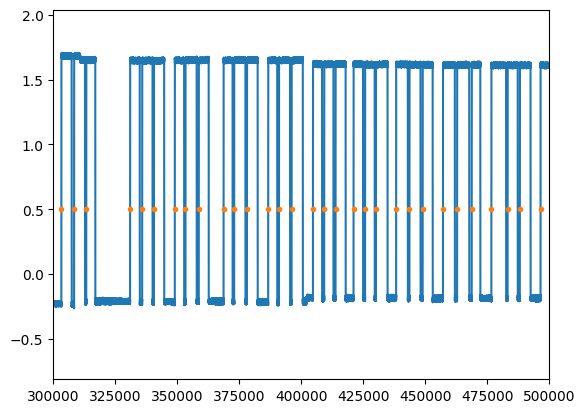

In [102]:
# plt.plot(neural_ts,'o')
# # plt.plot(pulses,'o')
# plt.show()

plt.plot(scipy.stats.zscore(temp_diode._data[:]))
# plt.plot(pulses)
plt.plot(np.array(pulses)*500, 
         np.ones_like(np.array(pulses)*500)-0.5, '.')
# plt.plot(neural_ts*1024, 
#          np.ones_like(neural_ts)-0.25, '.')
plt.xlim([300000,500000])
plt.show()

# temp_diode = photodiode_data.copy()
# temp_diode._data[0,0:1000000] = np.min(temp_diode._data[0,:])
# temp_diode._data[0,3000000:] = np.min(temp_diode._data[0,:])

In [103]:
print(slope, offset,smoothSize,windSize,height)

0.9999970698598646 325.35255137919387 11 15 1.0


In [837]:
# del epochs_all_baseline, power_epochs, plot_data

## Epoch Data
- Epoch neural data into trial epochs 
- Add behavioral data to epochs metadata
- Save epochs
- Baseline + decompose data into TFRs
- Plot + save TFRs (examine quality)

### Epoch data

In [104]:
# IED removal requires that we set some parameters for IED detection. 
# 1. peak_thresh: how many stds should they exceed the baseline by? 
# 2. closeness_thresh: how close should they be allowed to be (in sec) to other candidate IEDs? 
# 3. width_thresh: how wide should they have to be (in sec)?

# Defaults:
IED_args = {'peak_thresh':4,
           'closeness_thresh':0.25, 
           'width_thresh':0.2}

In [105]:
# Create a dictionary with your event name (matching your dataframe), and the time-window for the event
evs = {'TrialOnset': [-1.0, 0], #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [106]:
epochs_all_evs = {f'{x}': np.nan for x in evs}

In [107]:
for event in evs.keys():
    # Make the epochs. 
    ev_epochs = lfp_preprocess_utils.make_epochs(load_path=f'{neural_dir}{subj_id}/bp_ref_ieeg.fif', 
                 slope=slope, offset=offset,
                 behav_name=event, behav_times=behav_df[event].values,downsamp_factor=None,
#                  behav_name=event, behav_times=beh_ts,downsamp_factor=None,
                 ev_start_s=evs[event][0], ev_end_s=evs[event][1], buf_s = 1, IED_args=IED_args) #1.0 buf unsaved

    epochs_all_evs[event] = ev_epochs
    

Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif...
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-6 dB cutoff frequency: 90.00 Hz)
- Filter length: 265 samples (0.530 sec)



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    5.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    5.8s finished


Used Annotations descriptions: ['TrialOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 1501 original time points ...
0 bad epochs dropped
Adding metadata with 87 columns
Opening raw data file /sc/arion/projects/guLab/Alie/SWB/ephys_analysis/data/MS025/bp_ref_ieeg.fif...
    Range : 0 ... 1269503 =      0.000 ...  2539.006 secs
Ready.
Reading 0 ... 1269503  =      0.000 ...  2539.006 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 25 - 80 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 25.00
- Lower transition bandwidth: 6.25 Hz (-6 dB cutoff frequency: 21.88 Hz)
- Upper passband edge: 80.00 Hz
- Upper transition bandwidth: 20.00 Hz (-

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    3.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done  87 out of  87 | elapsed:    5.9s finished


Used Annotations descriptions: ['DecisionOnset']
Not setting metadata
150 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 150 events and 3501 original time points ...
0 bad epochs dropped
Adding metadata with 87 columns


In [108]:
epochs_all_evs 


{'TrialOnset': <Epochs |  150 events (all good), -2 - 1 sec, baseline off, ~149.6 MB, data loaded, with metadata,
  'TrialOnset': 150>,
 'DecisionOnset': <Epochs |  150 events (all good), -1 - 6 sec, baseline off, ~348.7 MB, data loaded, with metadata,
  'DecisionOnset': 150>}

### Add behavioral data to metadata 

In [109]:
behav_params = ['TrialType','SafeBet', 'LowBet', 'HighBet','GambleChoice', 'Outcome',
       'Profit', 'TotalProfit', 'GambleEV', 'CR', 'choiceEV', 'RPE',
       'totalCPE', 'decisionCPE', 'totalRegret', 'decisionRegret',
       'totalRelief', 'decisionRelief', 'totalCF', 'decisionCF', 'pRPE',
       'nRPE']


In [110]:
for event in evs.keys():

    event_metadata = epochs_all_evs[event].metadata.copy()
    
    #independent vars
    for param in behav_params: 
        event_metadata[param] = behav_df[param].tolist()

    epochs_all_evs[event].metadata = event_metadata 
    

Replacing existing metadata with 109 columns
Replacing existing metadata with 109 columns


In [111]:
epochs_all_evs[event].metadata

,lacas1-lacas2,lacas2-lacas3,lacas3-lacas4,lacas5-lacas6,laglt2-laglt3,laglt3-laglt4,laglt6-laglt7,laglt7-laglt8,laglt8-laglt9,lcmip1-lcmip2,...,totalCPE,decisionCPE,totalRegret,decisionRegret,totalRelief,decisionRelief,totalCF,decisionCF,pRPE,nRPE
0,NaN,NaN,NaN,NaN,[614.252],NaN,NaN,NaN,NaN,NaN,...,-1.12,-0.80,-1.12,-0.80,0.00,0.00,0.32,0.00,0.000,-0.56
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.91,0.50,0.00,0.00,0.91,0.50,-0.91,-0.50,0.455,0.00
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.41,0.41,0.00,0.00,0.41,0.41,-1.01,-1.01,0.000,0.00
3,NaN,NaN,NaN,NaN,[664.49],NaN,NaN,NaN,NaN,NaN,...,0.20,0.20,0.00,0.00,0.20,0.20,0.00,0.00,0.000,0.00
4,NaN,NaN,NaN,NaN,[679.05],NaN,NaN,NaN,NaN,NaN,...,-0.80,-0.40,-0.80,-0.40,0.00,0.00,0.80,0.40,0.000,-0.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-0.43,-0.43,-0.43,-0.43,0.00,0.00,0.63,0.63,0.000,0.00
146,NaN,NaN,NaN,NaN,[2429.014],NaN,NaN,NaN,NaN,NaN,...,-0.20,-0.20,-0.20,-0.20,0.00,0.00,0.00,0.00,0.000,0.00
147,NaN,NaN,NaN,NaN,NaN,[2447.384],NaN,NaN,NaN,NaN,...,0.40,0.40,0.00,0.00,0.40,0.40,0.00,0.00,0.000,0.00
148,NaN,NaN,NaN,NaN,NaN,NaN,noise,NaN,NaN,NaN,...,-0.74,-0.30,-0.74,-0.30,0.00,0.00,0.74,0.30,0.000,-0.37


### Save raw epoched data 

In [112]:
for event in evs.keys():
    epochs_all_evs[event].save(f'{neural_dir}{subj_id}/bp_epoch_{event}.fif', overwrite=True)

Overwriting existing file.
Overwriting existing file.


### Baseline + Decompose into TFRs

In [113]:
# Explicitly define a list of analysis events and the baseline event. Should correspond to the dict
analysis_evs = ['DecisionOnset']
baseline_ev = 'TrialOnset'
evs = {'TrialOnset': [-1.0, 0], #maybe increase to full second to take cycles up to 4
       #ITI is always at least one second + 10ms buffer for wavelet padding (no horizontal smearing)
       'DecisionOnset': [0, 5.0]} #1 sec decision period + 2 second outcome + 3 second counterfactual

In [114]:
# Set some spectrogram parameters 
freqs = np.logspace(*np.log10([2, 200]), num=30)
n_cycles = np.floor(np.logspace(*np.log10([3, 10]), num=30))


In [115]:
epochs_all_baseline = {} #removed unecessary 'decisiononset' empty key

In [116]:
#baseline epoch - 
event = 'TrialOnset' #or baseline_ev
epochs = epochs_all_evs[event]

good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

### this is new!
good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names): 
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0)
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                         freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]


temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)
temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])

epochs_all_baseline[event] = temp_pow


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.3s finished


In [117]:
epochs_all_baseline

{'TrialOnset': <EpochsTFR | time : [-1.000000, 0.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 87, ~1.46 GB>}

In [118]:
power_epochs = {}

In [119]:
event = 'DecisionOnset' # or analysis_evs

epochs = epochs_all_evs[event]

ch_names = epochs.ch_names

# Let's make sure we only do this for good channels
good_chans = [x for x in epochs.ch_names if x not in epochs.info['bads']]
picks = [x for x in good_chans]

pow_struct = np.nan * np.ones([epochs._data.shape[0], 
                       epochs._data.shape[1], len(freqs), 
                       epochs._data.shape[-1]])

good_epochs, bad_epochs = lfp_preprocess_utils.get_bad_epochs_by_chan(epochs)

for ch_ix, ch_name in enumerate(epochs.ch_names):
    ch_data = epochs._data[:, ch_ix:ch_ix+1, :]
    ch_data = np.delete(ch_data, bad_epochs[ch_name], axis=0) #this is where bad epochs for ch are deleted!!
    ch_pow = mne.time_frequency.tfr_array_morlet(ch_data, sfreq=epochs.info['sfreq'], 
                                        freqs=freqs, n_cycles=n_cycles, zero_mean=False, 
                                        use_fft=True, output='power', n_jobs=-1)

    pow_struct[good_epochs[ch_name], ch_ix, :, :] = ch_pow[:, 0, :, :]

temp_pow = mne.time_frequency.EpochsTFR(epochs.info, pow_struct, 
                                        epochs.times, freqs)

temp_pow.crop(tmin=evs[event][0], tmax=evs[event][1])


baseline_corrected_power = lfp_preprocess_utils.baseline_trialwise_TFR(data=temp_pow.data, 
                                                  baseline_mne=epochs_all_baseline['TrialOnset'].data, 
                                                  mode='zscore',ev_axis=0,elec_axis=1,
                                                  freq_axis=2,time_axis=3)


zpow = mne.time_frequency.EpochsTFR(epochs.info, baseline_corrected_power, 
                                temp_pow.times, freqs)

zpow.metadata = epochs_all_evs[event].metadata

power_epochs[event] = zpow



[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1

[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBacken

Not setting metadata


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:    0.9s finished


Not setting metadata
Adding metadata with 109 columns


In [120]:
power_epochs['DecisionOnset']

<EpochsTFR | time : [0.000000, 5.000000], freq : [2.000000, 200.000000], epochs : 150, channels : 87, ~7.30 GB>

In [121]:
#conda install -c conda-forge h5io must install to save tfr data
power_epochs['DecisionOnset'].save(f'{neural_dir}{subj_id}/bp_pow_epochs-tfr.h5', overwrite=True)


## Plot TFRs

In [122]:
####add directory for TFRs
tfr_dir = f'{base_dir}ephys_analysis/figs/TFRs/{subj_id}/all_trials/'
os.makedirs(tfr_dir,exist_ok = True) #added so you don't have to manually make subject folders in clean_data
date = datetime.date.today().strftime('%m%d%Y')

print(date)
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)

04072024


In [ ]:
#to reload for more cleaning if necessary
# mne_data_bp_reref = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/bp_ref_ieeg.fif',preload=True)
# mne_data = mne.io.read_raw_fif(f'{neural_dir}{subj_id}/raw_ieeg.fif',preload=True)

In [123]:
event = 'DecisionOnset'
good_ch = [x for x in power_epochs[event].ch_names if '-' in x]
save_path = tfr_dir

print(offset)


for ch in good_ch:
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    # same for all elec
    times = power_epochs[event].times
    # single ch tfr 
    plot_data = np.nanmean(np.nanmean(power_epochs[event].copy().pick_channels([ch]).data, axis=0), axis=0)

    im = ax.imshow(plot_data,interpolation='Bicubic',
            aspect='auto', origin='lower', cmap='RdBu_r',vmin = -np.nanmax(np.abs(plot_data)), 
                   vmax = np.nanmax(np.abs(plot_data)))
    

    ax.set(xlabel='Time (s)', ylabel='Frequency',title=f'{ch} Encoding',
           yticks=np.arange(0,len(freqs))[::5], 
           yticklabels=freqs[::5].astype(int), 
           xticks = np.arange(plot_data.shape[1])[::250],
              xticklabels= times[::250])
    fig.colorbar(im, ax=ax)
    
    plt.savefig(f'{save_path}/{ch}_{date}_bp_ref.png', format='png', metadata=None,
    bbox_inches=None, pad_inches=0.1,
    facecolor='auto', edgecolor='auto',
    backend=None)
    plt.close()


325.35255137919387
